# Evaluate segmentation model

This notebook is used to evaluate and inspect the model performance on a test dataset

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import logging

import torch
import lightning as pl
import matplotlib.pyplot as plt

from utils.logging import get_client_logger
from segmentation_model.dataset import PvSegmentationDataset
from segmentation_model.model import PvSegmentationModel

In [115]:
logger = get_client_logger(level="DEBUG")

logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

## Load eval dataset

In [116]:
RESIZE_SHAPE = (256, 256)

In [117]:
eval_dataset = PvSegmentationDataset(
    "../data/dop10rgbi_32_319_5654_1_nw_2023-20m",
    extension="bmp",
    mask_folder_name="masks",
    resize_shape=RESIZE_SHAPE,
)


In [118]:
BATCH_SIZE = 16

test_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Load model

In [119]:
model_path = '/Users/kopytjuk/Library/CloudStorage/OneDrive-Persönlich/Projekte/Solar Energy Yield/models/training-20250619-0841/stored_model/'

In [120]:
pv_model = PvSegmentationModel()
pv_model.load_model(model_path)

Loading weights from local directory


## Compute overall metrics

In [121]:
trainer = pl.Trainer()

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [122]:
test_metrics = trainer.test(pv_model, dataloaders=test_loader, verbose=False)
test_metrics = test_metrics[0]

/Users/kopytjuk/Code/roof-analysis/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]

2025-06-19 17:52:12,285 - fsspec.local - DEBUG - open file: /Users/kopytjuk/Code/roof-analysis/notebooks/lightning_logs/version_12/metrics.csv
2025-06-19 17:52:12,285 - fsspec.local - DEBUG - open file: /Users/kopytjuk/Code/roof-analysis/notebooks/lightning_logs/version_12/metrics.csv
2025-06-19 17:52:12,285 - fsspec.local - DEBUG - open file: /Users/kopytjuk/Code/roof-analysis/notebooks/lightning_logs/version_12/metrics.csv
2025-06-19 17:52:12,285 - fsspec.local - DEBUG - open file: /Users/kopytjuk/Code/roof-analysis/notebooks/lightning_logs/version_12/metrics.csv
2025-06-19 17:52:12,285 - fsspec.local - DEBUG - open file: /Users/kopytjuk/Code/roof-analysis/notebooks/lightning_logs/version_12/metrics.csv
2025-06-19 17:52:12,285 - fsspec.local - DEBUG - open file: /Users/kopytjuk/Code/roof-analysis/notebooks/lightning_logs/version_12/metrics.csv


Testing DataLoader 0: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


In [123]:
print(f"{test_metrics}")

{'test_per_image_iou': 0.7049806118011475, 'test_dataset_iou': 0.5445090532302856, 'test_loss': 0.2973226010799408}


## Visual inspection

In [124]:
mask_cmap = None# "binary"

/var/folders/wj/6vfql9yn0jl2jgcbcwflb88r0000gn/T/ipykernel_2736/3105439765.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


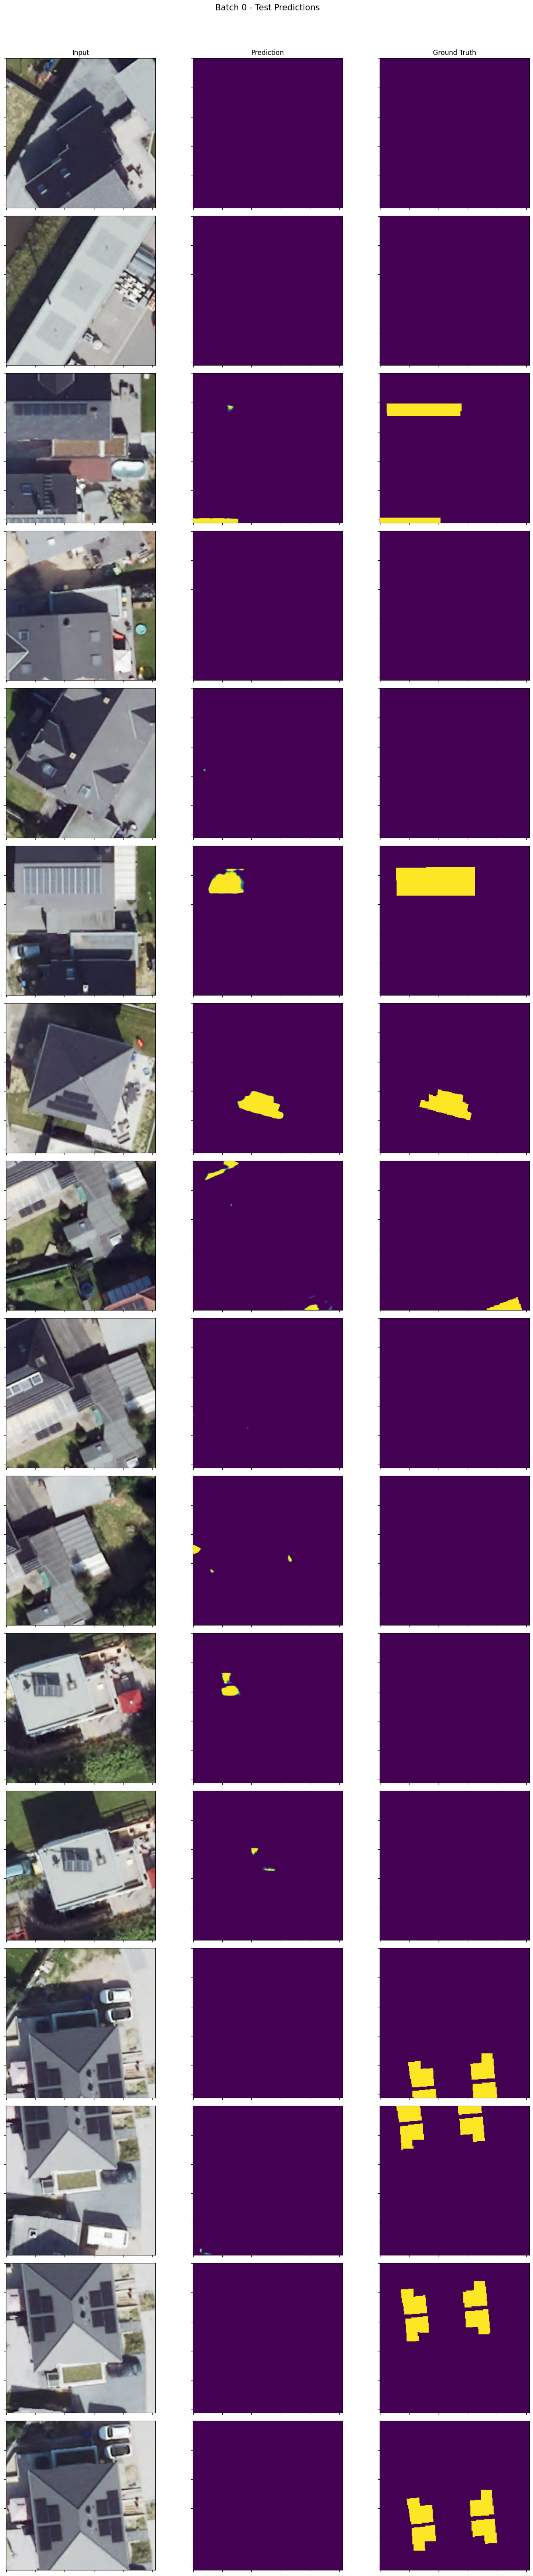

In [125]:
for batch_i, batch_data in enumerate(iter(test_loader)):
    images, gt_masks = batch_data

    num_samples = len(images)
    assert num_samples == BATCH_SIZE, f"Batch size mismatch: expected {BATCH_SIZE}, got {num_samples}"
    
    with torch.inference_mode():
        pv_model.eval()
        logits = pv_model.forward(images)
        pred_masks = logits.sigmoid()

    fig, ax_matrix = plt.subplots(figsize=(15, 4*BATCH_SIZE), nrows=BATCH_SIZE, ncols=3)

    fig.suptitle(f"Batch {batch_i} - Test Predictions", fontsize=15, y=1.01)

    for idx, (image, pred_mask, gt_mask) in enumerate(
        zip(images, pred_masks, gt_masks)
    ):
        
        ax_row = ax_matrix[idx]

        # from CHW to HWC
        image_arr = image.numpy().transpose(1, 2, 0)

        ax_row[0].imshow(image_arr)
        
        ax_row[1].imshow(pred_mask.numpy().squeeze(), vmin=0, vmax=1, cmap=mask_cmap)

        ax_row[2].imshow(gt_mask.numpy().squeeze(), vmin=0, vmax=1, cmap=mask_cmap)

        for ax in ax_row:
            # ax.set_xticks([])
            # ax.set_yticks([])

            # Remove tick labels
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
            # ax.set_axis_off()
        

        if idx == 0:
            ax_row[0].set_title("Input")
            ax_row[1].set_title("Prediction")
            ax_row[2].set_title("Ground Truth")

        # plt.savefig(f"batch_{batch_i}_sample_{idx}.png")
    fig.tight_layout()
    fig.show()

    break